# Enhanced Tennis Shot Classifier

This notebook provides a modular and robust framework for training and evaluating tennis shot classifiers using Recurrent Neural Networks (RNNs).

### Key Improvements Over Original Notebook:
1.  **K-Fold Cross-Validation**: Implements `StratifiedKFold` for more reliable and robust model evaluation, ensuring that class distributions are preserved in each fold.
2.  **Modular Model Architecture**: A new function, `get_models()`, allows you to easily define and experiment with multiple Keras model architectures (e.g., GRU, LSTM, deeper networks) without changing the training code.
3.  **Refactored Code**: Data loading, preprocessing, and model training logic have been encapsulated into separate, clean functions for better readability and reusability.
4.  **Automated Evaluation Summary**: The script automatically runs all defined models through the K-fold process and presents a clear summary of their performance (mean accuracy and standard deviation), making it easy to compare models.
5.  **Clear Workflow**: The notebook is structured logically: Configuration -> Data Loading -> Model Definition -> K-Fold CV -> Results Summary -> Final Evaluation.

## 1. Imports and Configuration

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
from tqdm.notebook import tqdm

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# --- Configuration ---
MERGE_SIMILAR_SHOTS = True
N_SPLITS = 5  # Number of folds for K-Fold Cross-Validation
EPOCHS = 100
BATCH_SIZE = 32

# --- Dataset Folders ---
TRAIN_FOLDERS = [
    # "Emma Raducanu Court Level Practice 2024 (4K 60FPS)", 
    # "Emma Raducanu ｜ Court Level Practice [4k 60fps]", 
    # "Novak Djokovic Volley & Smash Training Court Level View - ATP Tennis Practice", 
    # "World No.1 Iga Swiatek 2024 Court Level Practice with Caroline Garcia (4K 60FPS)",
    # "jsinner_h264",
    # "jsinner2_h264"
    "Novak Djokovic Volley & Smash Training Court Level View - ATP Tennis Practice",
    "emma2clean/Emma Raducanu ｜ Court Level Practice [4k 60fps]",
    "novaksmashclean/novaksmashclean", 
    "World No.1 Iga Swiatek 2024 Court Level Practice with Caroline Garcia (4K 60FPS)",
    "jsinner_h264",
    "jsinner2_h264",
    #"1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "8",
    "9",
    "emma1clean/Emma Raducanu Court Level Practice 2024 (4K 60FPS)"
    
]

TEST_FOLDERS = [
    #"Novak Djokovic & Alexander Zverev Condensed Court Level Practice 2024 4K 60FPS"
    
   
    ]

print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow Version: 2.19.0
Num GPUs Available:  0


## 2. Data Loading and Preprocessing
This function handles loading data from CSVs, merging shot classes, and returning features and labels.

In [10]:
def merge_shot_classes(shot_type, merge_similar=True):
    """Merge similar shot classes if requested."""
    if not merge_similar:
        return shot_type
    shot_mappings = {'overhead': 'serve', 'smash': 'serve'}
    return shot_mappings.get(shot_type, shot_type)

def load_data_from_folders(folders, base_path="dataset/"):
    """Loads all shot data from a list of folders."""
    X, y = [], []
    for folder in folders:
        dataset_path = os.path.join(base_path, folder)
        if not os.path.exists(dataset_path):
            print(f"Warning: {dataset_path} doesn't exist, skipping...")
            continue
        
        print(f"Loading shots from {folder}")
        csv_files = [f for f in os.listdir(dataset_path) if f.endswith('.csv')]
        
        for shot_csv in tqdm(sorted(csv_files), desc=f"Processing {folder}"):
            data = pd.read_csv(os.path.join(dataset_path, shot_csv))
            name_parts = shot_csv.replace('.csv', '').split('_')
            
            # Determine shot type from filename
            if len(name_parts) >= 3 and name_parts[1] in ['volley', 'slice']:
                shot_type = f"{name_parts[0]}_{name_parts[1]}"
            else:
                shot_type = name_parts[0]
            
            shot_type = merge_shot_classes(shot_type, MERGE_SIMILAR_SHOTS)
            features = data.loc[:, data.columns != 'shot']
            X.append(features.to_numpy())
            y.append(shot_type)
            
    return np.stack(X, axis=0), np.array(y)

# Load the training and test datasets
X_train_full, y_train_full = load_data_from_folders(TRAIN_FOLDERS)


print(f"\nLoaded {len(y_train_full)} shots for training/validation.")

print(f"\nFeature shape: {X_train_full.shape}")
print(f"Unique shot types: {np.unique(y_train_full)}")
# X_test, y_test = load_data_from_folders(TEST_FOLDERS)
# print(f"Loaded {len(y_test)} shots for final testing.")

Loading shots from Novak Djokovic Volley & Smash Training Court Level View - ATP Tennis Practice


Processing Novak Djokovic Volley & Smash Training Court Level View - ATP Tennis Practice:   0%|          | 0/1…

Loading shots from emma2clean/Emma Raducanu ｜ Court Level Practice [4k 60fps]


Processing emma2clean/Emma Raducanu ｜ Court Level Practice [4k 60fps]:   0%|          | 0/300 [00:00<?, ?it/s]

Loading shots from novaksmashclean/novaksmashclean


Processing novaksmashclean/novaksmashclean:   0%|          | 0/32 [00:00<?, ?it/s]

Loading shots from World No.1 Iga Swiatek 2024 Court Level Practice with Caroline Garcia (4K 60FPS)


Processing World No.1 Iga Swiatek 2024 Court Level Practice with Caroline Garcia (4K 60FPS):   0%|          | …

Loading shots from jsinner_h264


Processing jsinner_h264:   0%|          | 0/578 [00:00<?, ?it/s]

Loading shots from jsinner2_h264


Processing jsinner2_h264:   0%|          | 0/459 [00:00<?, ?it/s]

Loading shots from 2


Processing 2:   0%|          | 0/11 [00:00<?, ?it/s]

Loading shots from 3


Processing 3:   0%|          | 0/1 [00:00<?, ?it/s]

Loading shots from 4


Processing 4:   0%|          | 0/24 [00:00<?, ?it/s]

Loading shots from 5


Processing 5:   0%|          | 0/23 [00:00<?, ?it/s]

Loading shots from 6


Processing 6:   0%|          | 0/571 [00:00<?, ?it/s]

Loading shots from 8


Processing 8:   0%|          | 0/72 [00:00<?, ?it/s]

Loading shots from 9


Processing 9:   0%|          | 0/181 [00:00<?, ?it/s]

Loading shots from emma1clean/Emma Raducanu Court Level Practice 2024 (4K 60FPS)


Processing emma1clean/Emma Raducanu Court Level Practice 2024 (4K 60FPS):   0%|          | 0/251 [00:00<?, ?it…


Loaded 2791 shots for training/validation.

Feature shape: (2791, 30, 26)
Unique shot types: ['backhand' 'backhand_slice' 'backhand_volley' 'forehand'
 'forehand_volley' 'neutral' 'serve']


Total shots            : 2,791
Unique shot classes    : 7
Time-steps per sample  : 30
Features per time-step : 26


,n_samples
neutral,1367
forehand,604
backhand,394
serve,196
forehand_volley,80
backhand_volley,78
backhand_slice,72


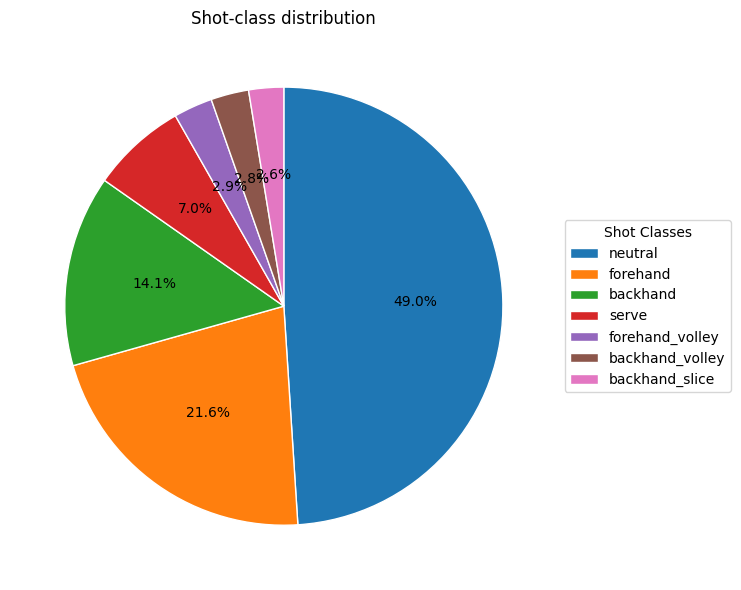

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# 1. Basic dimensions
print(f"Total shots            : {len(y_train_full):,}")
print(f"Unique shot classes    : {np.unique(y_train_full).size}")
print(f"Time-steps per sample  : {X_train_full.shape[1]}")
print(f"Features per time-step : {X_train_full.shape[2]}")

# 2. Per-class sample counts
class_counts = Counter(y_train_full)
counts_df = (
    pd.DataFrame.from_dict(class_counts, orient="index", columns=["n_samples"])
      .sort_values("n_samples", ascending=False)
)
display(counts_df)

# 3. Bar-chart of the class distribution
plt.figure(figsize=(8, 6))
wedges, texts, autotexts = plt.pie(
    counts_df.n_samples,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    wedgeprops={"edgecolor": "white"}
)
plt.title("Shot-class distribution")

plt.legend(wedges, counts_df.index,
          title="Shot Classes",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.savefig("pie_chart_with_legend.png")

## 3. Modular Model Definition

This section provides a flexible way to define multiple model architectures. To test a new model, simply add a new function that builds it and add it to the `get_models` dictionary. The rest of the pipeline will handle it automatically.

In [12]:
def create_simple_gru_model(input_shape, num_classes):
    """Creates the simple GRU model from the original notebook."""
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.GRU(units=128, dropout=0.2),
        layers.Dense(units=16, activation='relu'),
        layers.Dense(units=num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_simple_lstm_model(input_shape, num_classes):
    """A simple LSTM-based model, analogous to the GRU model."""
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(units=64, dropout=0.2),
        layers.Dense(units=16, activation='relu'),
        layers.Dense(units=num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_bidirectional_lstm_model(input_shape, num_classes):
    """A Bidirectional LSTM model to process sequences from both directions."""
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Bidirectional(layers.LSTM(units=64, dropout=0.2)),
        layers.Dense(units=16, activation='relu'),
        layers.Dense(units=num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_cnn_model(input_shape, num_classes):
    """A 1D CNN model for sequence classification."""
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
        layers.Dropout(0.3),
        layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
        layers.GlobalMaxPooling1D(),
        layers.Dense(units=16, activation='relu'),
        layers.Dense(units=num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_cnn_gru_hybrid_model(input_shape, num_classes):
    """A hybrid model combining a CNN feature extractor with a GRU."""
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),
        layers.GRU(units=32, dropout=0.2),
        layers.Dense(units=16, activation='relu'),
        layers.Dense(units=num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
def create_original_gru_model(input_shape, num_classes):
    """The exact simpler GRU model from the original notebook."""
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.GRU(units=24, dropout=0.1),
        layers.Dropout(0.2),
        layers.Dense(units=8, activation='relu'),
        layers.Dense(units=num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def get_models(input_shape, num_classes):
    """
    Returns a dictionary of model-building functions.
    Key: A descriptive name for the model.
    Value: The function that creates the compiled Keras model.
    """
    return {
        'Original_GRU': lambda: create_original_gru_model(input_shape, num_classes),
        'Simple_GRU': lambda: create_simple_gru_model(input_shape, num_classes),
        'Simple_LSTM': lambda: create_simple_lstm_model(input_shape, num_classes),
        'BiLSTM': lambda: create_bidirectional_lstm_model(input_shape, num_classes),
        '1D_CNN': lambda: create_cnn_model(input_shape, num_classes),
        'CNN_GRU_Hybrid': lambda: create_cnn_gru_hybrid_model(input_shape, num_classes),
    }


## 4. K-Fold Cross-Validation Runner

This is the core of the new workflow. It takes the full training dataset and evaluates each model defined in `get_models()` using Stratified K-Fold Cross-Validation. This provides a much more robust measure of model performance than a single train/validation split.

In [5]:
# ==============================================================================
# K-FOLD EVALUATION FUNCTION (Updated with Confusion Matrix + Learning Curves)
# ==============================================================================
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import plot_model
import pydot
from IPython.display import Image

def run_kfold_evaluation(X, y, N_SPLITS, EPOCHS, BATCH_SIZE, save_dir="best_models_by_architecture"):
    """
    Runs k-fold CV to evaluate architectures, then retrains each architecture
    on the full dataset and saves the final models.
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"Created directory: {save_dir}")

    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    num_classes = len(le.classes_)
    input_shape = X.shape[1:]

    # Assumes get_models() is defined elsewhere and returns a dict of model builders
    models_to_test = get_models(input_shape, num_classes)
    all_results = {}

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

    # --- Stage 1: Evaluate architectures using K-Fold CV ---
    print("\n--- Stage 1: Evaluating architectures using K-Fold Cross-Validation ---")
    for model_name, model_builder in models_to_test.items():
        print(f"\n--- Evaluating Model: {model_name} ---")
        fold_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}

        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_encoded)):
            print(f"  - Fold {fold + 1}/{N_SPLITS}")
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

            class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
            class_weight_dict = dict(enumerate(class_weights))

            y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
            y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)
            
            model = model_builder()
            plot_model(
                model,
                to_file=f"{model_name}.png",   # output filename
                show_shapes=True,               # show tensor shapes
                show_layer_names=True,          # include layer names
                expand_nested=True,             # expand if you use nested models
                dpi=100
            )
            Image(f"{model_name}.png")
            callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
            history = model.fit(
                X_train, y_train_cat,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                class_weight=class_weight_dict,
                validation_data=(X_val, y_val_cat),
                callbacks=callbacks,
                verbose=0
            )

            # # === NEW: Learning Curves ===
            # plt.figure(figsize=(12,5))
            # # Accuracy
            # plt.subplot(1,2,1)
            # plt.plot(history.history["accuracy"], label="Train Acc")
            # plt.plot(history.history["val_accuracy"], label="Val Acc")
            # plt.title(f"{model_name} - Fold {fold+1} Accuracy")
            # plt.xlabel("Epochs")
            # plt.ylabel("Accuracy")
            # plt.legend()
            # plt.grid(True)

            # # Loss
            # plt.subplot(1,2,2)
            # plt.plot(history.history["loss"], label="Train Loss")
            # plt.plot(history.history["val_loss"], label="Val Loss")
            # plt.title(f"{model_name} - Fold {fold+1} Loss")
            # plt.xlabel("Epochs")
            # plt.ylabel("Loss")
            # plt.legend()
            # plt.grid(True)
            # plt.show()

            # # === NEW: Confusion Matrix ===
            y_pred_probs = model.predict(X_val, verbose=0)
            y_pred = np.argmax(y_pred_probs, axis=1)

            # cm = confusion_matrix(y_val, y_pred)
            # plt.figure(figsize=(8,6))
            # sns.heatmap(
            #     cm, annot=True, fmt="d", cmap="Blues",
            #     xticklabels=le.classes_,
            #     yticklabels=le.classes_
            # )
            # plt.xlabel("Predicted")
            # plt.ylabel("True")
            # plt.title(f"{model_name} - Fold {fold+1} Confusion Matrix")
            # plt.show()

            # === Classification Report & Metrics ===
            print(f"\n   Classification Report for Fold {fold + 1}:")
            print(classification_report(y_val, y_pred, target_names=le.classes_, zero_division=0))

            loss, accuracy = model.evaluate(X_val, y_val_cat, verbose=0)
            precision = precision_score(y_val, y_pred, average='weighted', zero_division=0)
            recall = recall_score(y_val, y_pred, average='weighted', zero_division=0)
            f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)

            fold_metrics['accuracy'].append(accuracy)
            fold_metrics['precision'].append(precision)
            fold_metrics['recall'].append(recall)
            fold_metrics['f1_score'].append(f1)

        # After all folds
        all_results[model_name] = {metric: np.mean(values) for metric, values in fold_metrics.items()}
        
        print(f"--- Average CV Results for {model_name} ---")
        print(f" > Accuracy:  {all_results[model_name]['accuracy']:.4f}")
        print(f" > Precision: {all_results[model_name]['precision']:.4f} (Weighted Avg)")
        print(f" > Recall:    {all_results[model_name]['recall']:.4f} (Weighted Avg)")
        print(f" > F1-Score:  {all_results[model_name]['f1_score']:.4f} (Weighted Avg)")

    return all_results, le


# Run the evaluation (example usage remains the same)
kfold_results, label_encoder = run_kfold_evaluation(
    X_train_full,
    y_train_full,
    3,
    300,
    32,
    "best_models_by_architecture"
)

from tensorflow.keras.utils import plot_model


--- Stage 1: Evaluating architectures using K-Fold Cross-Validation ---

--- Evaluating Model: Original_GRU ---
  - Fold 1/3

   Classification Report for Fold 1:
                 precision    recall  f1-score   support

       backhand       0.91      0.80      0.85       132
 backhand_slice       0.59      0.92      0.72        24
backhand_volley       0.60      0.81      0.69        26
       forehand       0.93      0.87      0.90       201
forehand_volley       0.43      0.93      0.59        27
        neutral       0.96      0.92      0.94       455
          serve       1.00      0.91      0.95        66

       accuracy                           0.89       931
      macro avg       0.77      0.88      0.81       931
   weighted avg       0.91      0.89      0.89       931

  - Fold 2/3

   Classification Report for Fold 2:
                 precision    recall  f1-score   support

       backhand       0.90      0.88      0.89       131
 backhand_slice       0.60      0.88    

## 5. Cross-Validation Results Summary

The table below shows the mean accuracy and standard deviation for each model across all `k` folds. This helps in selecting the best, most stable model architecture for final training.


--- Stage 1: Evaluating architectures using K-Fold Cross-Validation ---

--- Evaluating Model: Original_GRU ---
  - Fold 1/3
  - Fold 2/3
  - Fold 3/3
  > Average CV Results for Original_GRU:
    - Accuracy:  0.9076
    - Precision: 0.9243
    - Recall:    0.9076
    - F1-Score:  0.9132

--- Evaluating Model: Simple_GRU ---
  - Fold 1/3
  - Fold 2/3
  - Fold 3/3
  > Average CV Results for Simple_GRU:
    - Accuracy:  0.9072
    - Precision: 0.9215
    - Recall:    0.9072
    - F1-Score:  0.9116

--- Evaluating Model: Simple_LSTM ---
  - Fold 1/3
  - Fold 2/3
  - Fold 3/3
  > Average CV Results for Simple_LSTM:
    - Accuracy:  0.9144
    - Precision: 0.9230
    - Recall:    0.9144
    - F1-Score:  0.9168

--- Evaluating Model: BiLSTM ---
  - Fold 1/3
  - Fold 2/3
  - Fold 3/3
  > Average CV Results for BiLSTM:
    - Accuracy:  0.9208
    - Precision: 0.9279
    - Recall:    0.9208
    - F1-Score:  0.9229

--- Evaluating Model: 1D_CNN ---
  - Fold 1/3
  - Fold 2/3
  - Fold 3/3
  > Average CV Results for 1D_CNN:
    - Accuracy:  0.9144
    - Precision: 0.9268
    - Recall:    0.9144
    - F1-Score:  0.9180

--- Evaluating Model: CNN_GRU_Hybrid ---
  - Fold 1/3
  - Fold 2/3
  - Fold 3/3
  > Average CV Results for CNN_GRU_Hybrid:
    - Accuracy:  0.9248
    - Precision: 0.9347
    - Recall:    0.9248
    - F1-Score:  0.9276

--- Stage 1: Evaluating architectures using K-Fold Cross-Validation ---

--- Evaluating Model: Original_GRU ---
  - Fold 1/3

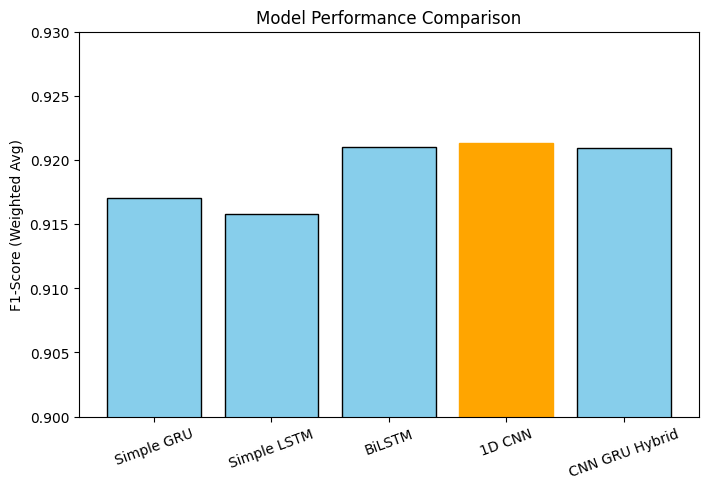

In [8]:
import matplotlib.pyplot as plt

# F1-scores (weighted avg) from your CV results
f1_scores = {
    "Simple GRU": 0.9170,
    "Simple LSTM": 0.9158,
    "BiLSTM": 0.9210,
    "1D CNN": 0.9213,
    "CNN GRU Hybrid": 0.9209,  # updated from CV results
}

plt.figure(figsize=(8, 5))
bars = plt.bar(f1_scores.keys(), f1_scores.values(), color="skyblue", edgecolor="black")

# Highlight best performing model
best_model = max(f1_scores, key=f1_scores.get)
bars[list(f1_scores.keys()).index(best_model)].set_color("orange")

plt.ylim(0.90, 0.93)  # zoom into the range
plt.ylabel("F1-Score (Weighted Avg)")
plt.title("Model Performance Comparison")
plt.xticks(rotation=20)
plt.show()


In [8]:
summary_data = []
for model_name, accuracies in kfold_results.items():
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    summary_data.append({
        'Model': model_name,
        f'Mean Accuracy ({N_SPLITS}-Fold CV)': f"{mean_acc:.4f}",
        f'Std Deviation': f"{std_acc:.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print("--- K-Fold Cross-Validation Summary ---")
display(summary_df.set_index('Model'))

--- K-Fold Cross-Validation Summary ---


,Mean Accuracy (5-Fold CV),Std Deviation
Model,,
Simple_GRU,0.9118,0.0157
Simple_LSTM,0.9138,0.0134
BiLSTM,0.9165,0.0171
1D_CNN,0.9165,0.0041
CNN_GRU_Hybrid,0.9189,0.0138


## 6. Final Model Training and Evaluation

After selecting the best model architecture based on the CV results, we train it on the *entire* training dataset (`X_train_full`, `y_train_full`). Then, we perform a final, definitive evaluation on the held-out test set (`X_test`, `y_test`).

In [14]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plots a confusion matrix using Seaborn."""
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    plt.figure(figsize=(12, 10))
    sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix', fontsize=20)
    plt.xlabel('Predicted Label', fontsize=15)
    plt.ylabel('True Label', fontsize=15)
    plt.show()

# --- Train and Evaluate the Best Model ---

# 1. Select the best model (e.g., based on highest mean accuracy)
best_model_name = summary_df.sort_values(by=f'Mean Accuracy ({N_SPLITS}-Fold CV)', ascending=False).iloc[0]['Model']
print(f"Proceeding with the best model: '{best_model_name}' for final evaluation.")

# 2. Prepare the full dataset for final training
num_classes = len(label_encoder.classes_)
input_shape = X_train_full.shape[1:]
y_train_encoded = label_encoder.transform(y_train_full)
y_train_cat = tf.keras.utils.to_categorical(y_train_encoded, num_classes=num_classes)

y_test_encoded = label_encoder.transform(y_test)
y_test_cat = tf.keras.utils.to_categorical(y_test_encoded, num_classes=num_classes)

# 3. Build a new instance of the best model
models = get_models(input_shape, num_classes)
final_model = models[best_model_name]()

# 4. Train on the full training data
print("\nTraining the final model on the entire training dataset...")
class_weights_final = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weight_dict_final = dict(enumerate(class_weights_final))

final_model.fit(X_train_full, y_train_cat,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                class_weight=class_weight_dict_final,
                callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=10)],
                verbose=1)

# 5. Evaluate on the held-out test set
print("\n--- Final Evaluation on Test Set ---")
loss, accuracy = final_model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

# 6. Plot the confusion matrix
test_preds = final_model.predict(X_test)
test_pred_classes = np.argmax(test_preds, axis=1)

plot_confusion_matrix(y_test_encoded, test_pred_classes, label_encoder.classes_)

NameError: name 'summary_df' is not defined

## 7. Qualitative Analysis: Visualizing Predictions

Finally, we can visualize some predictions on the test set to get a qualitative feel for the model's performance. The helper function `to_gif` converts the skeleton data into an animation.

In [13]:
import imageio
import random
from IPython.display import Image, display
import cv2

def to_gif(shot):
    KEYPOINTS = ["nose", "left_shoulder", "right_shoulder", "left_elbow", "right_elbow", "left_wrist", "right_wrist", "left_hip", "right_hip", "left_knee", "right_knee", "left_ankle", "right_ankle"]
    KEYPOINTS_DICT = {name: i for i, name in enumerate(KEYPOINTS)}
    EDGES = [("nose", "left_shoulder"), ("nose", "right_shoulder"), ("left_shoulder", "left_elbow"), ("left_elbow", "left_wrist"), ("right_shoulder", "right_elbow"), ("right_elbow", "right_wrist"), ("left_shoulder", "right_shoulder"), ("left_shoulder", "left_hip"), ("right_shoulder", "right_hip"), ("left_hip", "right_hip"), ("left_hip", "left_knee"), ("left_knee", "left_ankle"), ("right_hip", "right_knee"), ("right_knee", "right_ankle")]
    height, width = 500, 500
    frames = []
    
    for i in range(len(shot)):
        frame = np.zeros((height, width, 3), np.uint8)
        shot_inst = shot[i, :]
        
        for k in range(len(KEYPOINTS)):
            x, y = int(shot_inst[2*k+1] * width), int(shot_inst[2*k] * height)
            if x > 0 and y > 0: # Only draw visible keypoints
                cv2.circle(frame, (x, y), radius=5, color=(0, 255, 0), thickness=-1)
        
        for edge in EDGES:
            p1_idx, p2_idx = KEYPOINTS_DICT[edge[0]], KEYPOINTS_DICT[edge[1]]
            y1, x1 = int(shot_inst[2*p1_idx] * height), int(shot_inst[2*p1_idx+1] * width)
            y2, x2 = int(shot_inst[2*p2_idx] * height), int(shot_inst[2*p2_idx+1] * width)
            if x1 > 0 and y1 > 0 and x2 > 0 and y2 > 0:
                cv2.line(frame, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)
        frames.append(frame)
        
    return np.array(frames)

def display_prediction(idx):
    # Get the sample
    sample_x = X_test[idx]
    true_label_encoded = y_test_encoded[idx]
    true_label_name = label_encoder.inverse_transform([true_label_encoded])[0]
    
    # Get model prediction
    pred_probs = test_preds[idx]
    pred_label_encoded = np.argmax(pred_probs)
    pred_label_name = label_encoder.inverse_transform([pred_label_encoded])[0]
    
    # Create and display GIF
    gif_path = "animation.gif"
    converted_images = to_gif(sample_x)
    imageio.mimsave(gif_path, converted_images, fps=15)
    
    print(f"--- Prediction for Sample #{idx} ---")
    print(f"Ground Truth: {true_label_name}")
    print(f"Prediction: {pred_label_name} ({pred_probs[pred_label_encoded]:.2%} confidence)")
    
    print("\nPrediction Probabilities:")
    for i, class_name in enumerate(label_encoder.classes_):
        print(f"  - {class_name}: {pred_probs[i]:.2%}")
        
    display(Image(filename=gif_path))

# Display a random prediction
random_idx = random.randint(0, len(X_test) - 1)
display_prediction(random_idx)

NameError: name 'X_test' is not defined

In [15]:
def to_gif(shot):
    KEYPOINTS = ["nose", "left_shoulder", "right_shoulder", "left_elbow", "right_elbow", "left_wrist", "right_wrist", "left_hip", "right_hip", "left_knee", "right_knee", "left_ankle", "right_ankle"]
    EDGES = [("nose", "left_shoulder"), ("nose", "right_shoulder"), ("left_shoulder", "left_elbow"), ("left_elbow", "left_wrist"), ("right_shoulder", "right_elbow"), ("right_elbow", "right_wrist"), ("left_shoulder", "right_shoulder"), ("left_shoulder", "left_hip"), ("right_shoulder", "right_hip"), ("left_hip", "right_hip"), ("left_hip", "left_knee"), ("left_knee", "left_ankle"), ("right_hip", "right_knee"), ("right_knee", "right_ankle")]
    height, width = 500, 500
    frames = []

    for i in range(len(shot)):
        frame = np.zeros((height, width, 3), np.uint8)
        shot_inst = shot[i, :]

        for k in range(len(KEYPOINTS)):
            # The keypoint coordinates are (y, x), so we must be careful here
            y, x = int(shot_inst[2*k] * height), int(shot_inst[2*k+1] * width)
            if x > 0 and y > 0: # Only draw visible keypoints
                cv2.circle(frame, (x, y), radius=5, color=(0, 255, 0), thickness=-1)

        keypoints_dict = {name: i for i, name in enumerate(KEYPOINTS)}
        for edge in EDGES:
            p1_idx, p2_idx = keypoints_dict[edge[0]], keypoints_dict[edge[1]]
            y1, x1 = int(shot_inst[2*p1_idx] * height), int(shot_inst[2*p1_idx+1] * width)
            y2, x2 = int(shot_inst[2*p2_idx] * height), int(shot_inst[2*p2_idx+1] * width)
            if x1 > 0 and y1 > 0 and x2 > 0 and y2 > 0:
                cv2.line(frame, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)
        frames.append(frame)

    return np.array(frames)

# --- NEW FUNCTION ---
def display_class_samples(X_data, y_data, class_name, num_samples=10):
    """
    Displays a specified number of random sample GIFs for a given class.

    Args:
        X_data (np.array): The feature data (all shots).
        y_data (np.array): The label data (all shot types).
        class_name (str): The name of the class to display (e.g., 'serve').
        num_samples (int): The number of random samples to display.
    """
    print(f"Searching for class: '{class_name}'...")

    # 1. Find all indices that match the requested class_name
    class_indices = np.where(y_data == class_name)[0]

    if len(class_indices) == 0:
        print(f"❌ Could not find any samples for class '{class_name}'.")
        print(f"Available classes are: {np.unique(y_data)}")
        return

    # 2. Select random samples, ensuring we don't request more than exist
    num_to_show = min(num_samples, len(class_indices))
    random_indices = np.random.choice(class_indices, size=num_to_show, replace=False)

    print(f"✅ Found {len(class_indices)} samples. Displaying {num_to_show} random GIFs for '{class_name}'.")

    # 3. Loop, create a GIF, and display for each selected sample
    for idx in random_indices:
        sample_x = X_data[idx]
        gif_path = "temp_class_display.gif"

        # Generate and save the GIF
        converted_images = to_gif(sample_x)
        imageio.mimsave(gif_path, converted_images, fps=15)

        print(f"\n--- Displaying Sample from Index: {idx} ---")
        display(Image(filename=gif_path))
        # Optional: Clean up the generated GIF file
        # os.remove(gif_path)

Searching for class: 'serve'...
✅ Found 196 samples. Displaying 10 random GIFs for 'serve'.

--- Displaying Sample from Index: 1649 ---


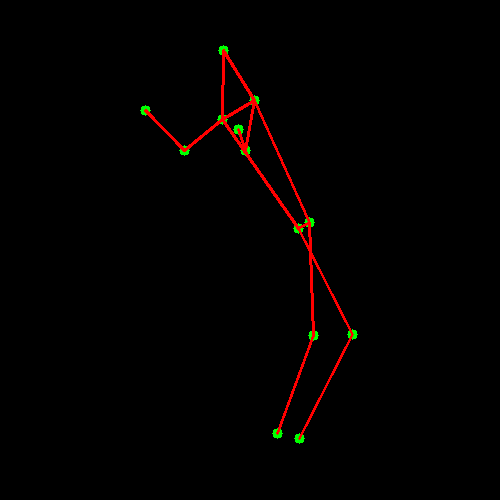


--- Displaying Sample from Index: 1626 ---


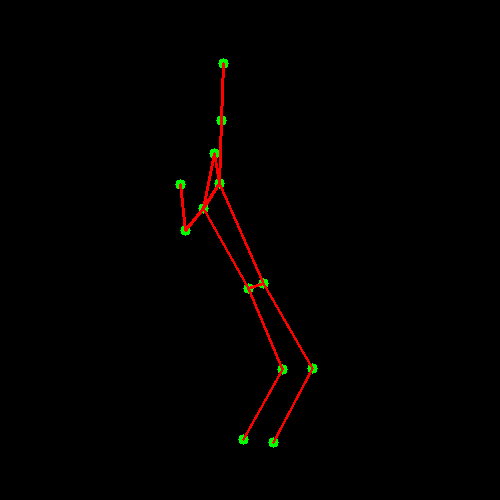


--- Displaying Sample from Index: 2790 ---


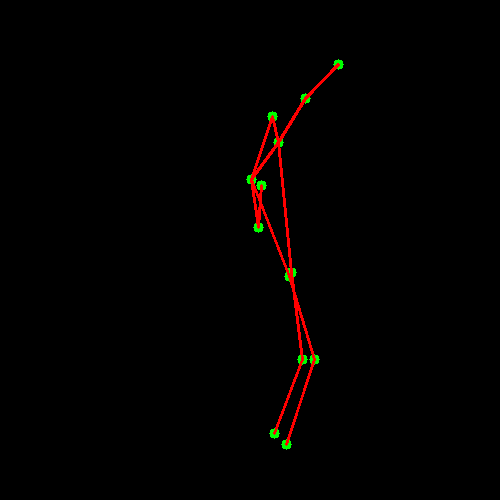


--- Displaying Sample from Index: 103 ---


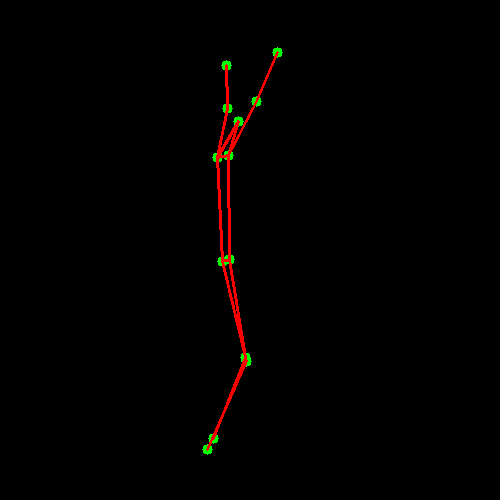


--- Displaying Sample from Index: 2529 ---


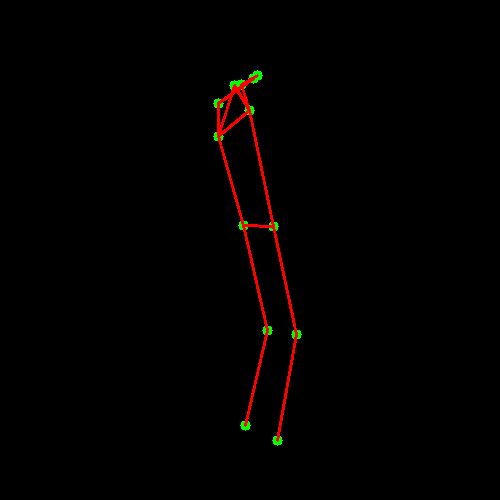


--- Displaying Sample from Index: 1196 ---


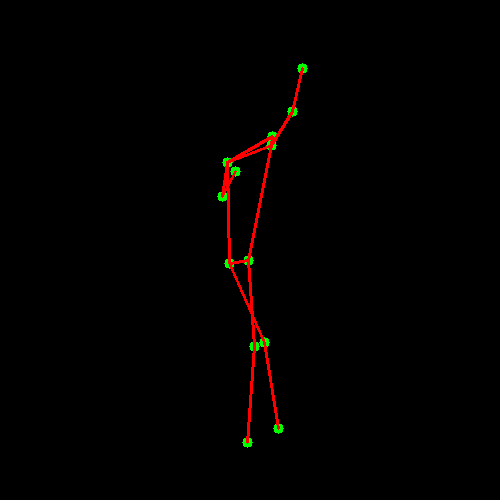


--- Displaying Sample from Index: 104 ---


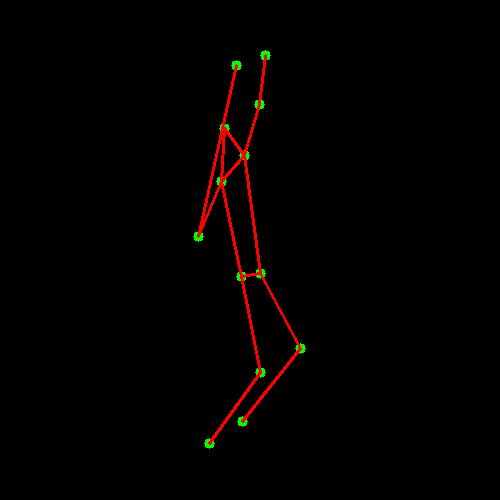


--- Displaying Sample from Index: 1195 ---


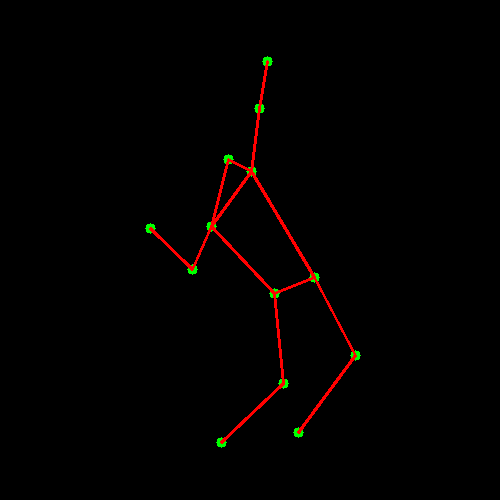


--- Displaying Sample from Index: 1174 ---


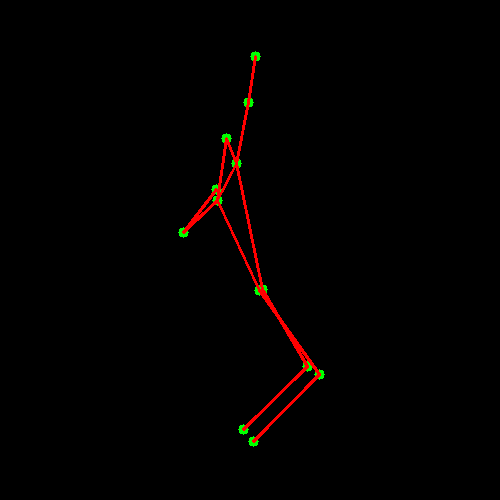


--- Displaying Sample from Index: 2267 ---


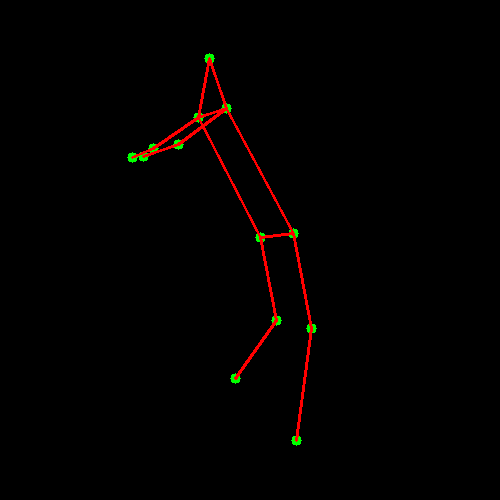

In [16]:
display_class_samples(X_train_full, y_train_full, class_name='serve', num_samples=10)

Searching for class: 'backhand'...
✅ Found 394 samples. Displaying 10 random GIFs for 'backhand'.

--- Displaying Sample from Index: 669 ---


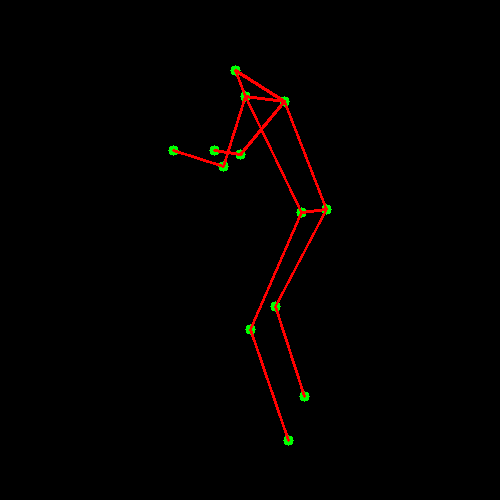


--- Displaying Sample from Index: 682 ---


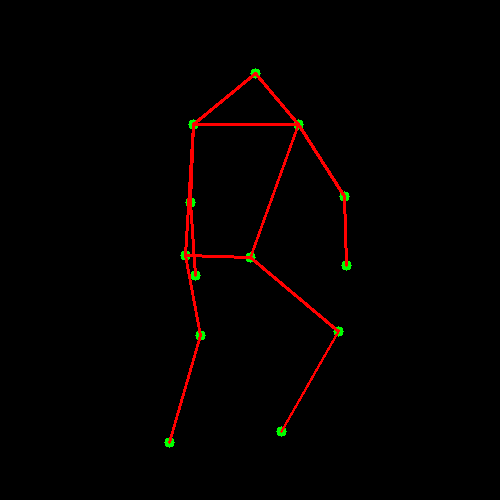


--- Displaying Sample from Index: 1717 ---


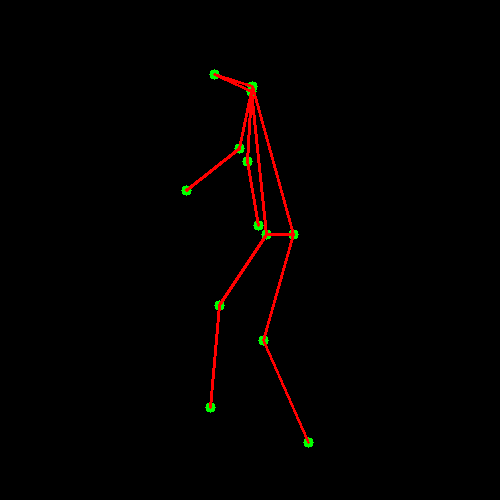


--- Displaying Sample from Index: 2585 ---


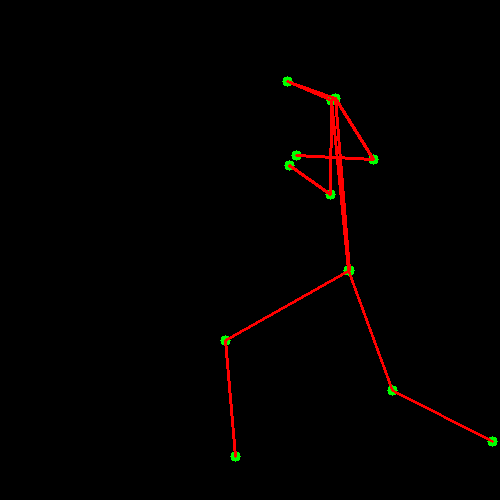


--- Displaying Sample from Index: 411 ---


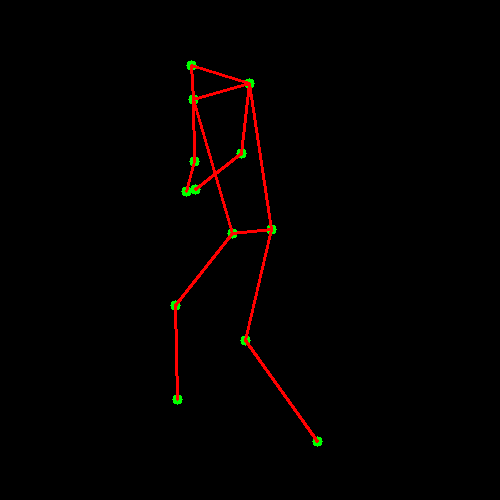


--- Displaying Sample from Index: 2575 ---


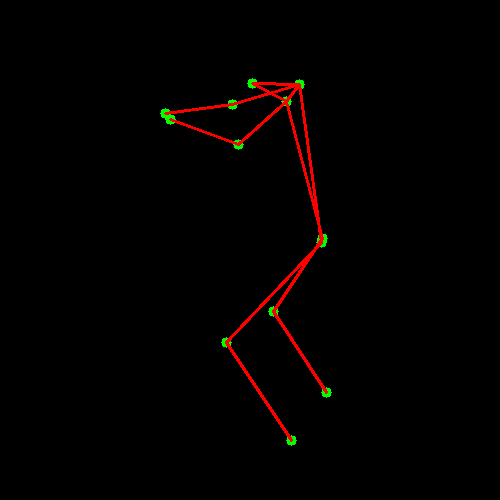


--- Displaying Sample from Index: 1719 ---


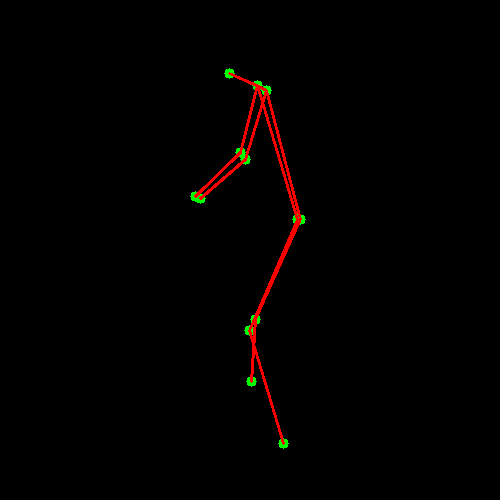


--- Displaying Sample from Index: 1786 ---


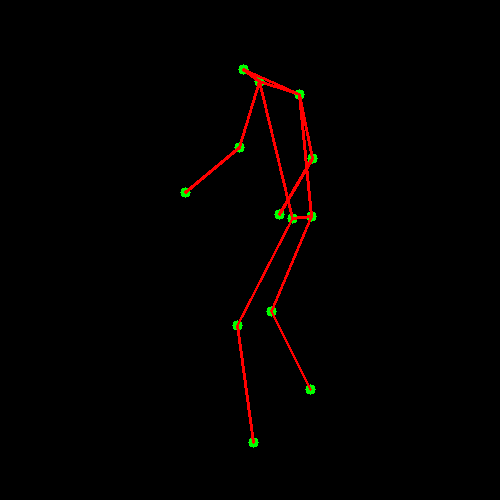


--- Displaying Sample from Index: 465 ---


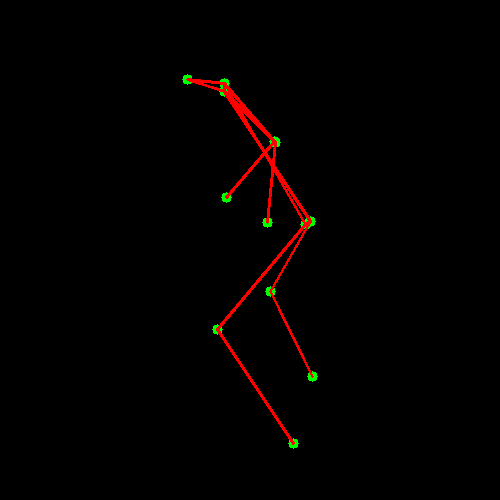


--- Displaying Sample from Index: 2579 ---


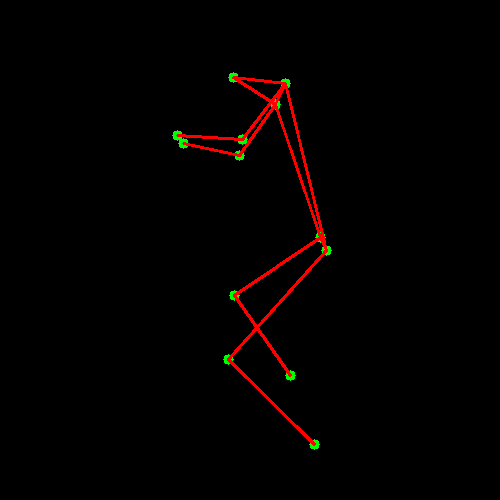

In [17]:
display_class_samples(X_train_full, y_train_full, class_name='backhand', num_samples=10)

In [18]:
import numpy as np
import imageio
import random
from IPython.display import Image, display
import cv2
import os
from tqdm import tqdm # Using tqdm for a nice progress bar

# This is your original GIF conversion function, required for the script to work.
def to_gif(shot):
    KEYPOINTS = ["nose", "left_shoulder", "right_shoulder", "left_elbow", "right_elbow", "left_wrist", "right_wrist", "left_hip", "right_hip", "left_knee", "right_knee", "left_ankle", "right_ankle"]
    EDGES = [("nose", "left_shoulder"), ("nose", "right_shoulder"), ("left_shoulder", "left_elbow"), ("left_elbow", "left_wrist"), ("right_shoulder", "right_elbow"), ("right_elbow", "right_wrist"), ("left_shoulder", "right_shoulder"), ("left_shoulder", "left_hip"), ("right_shoulder", "right_hip"), ("left_hip", "right_hip"), ("left_hip", "left_knee"), ("left_knee", "left_ankle"), ("right_hip", "right_knee"), ("right_knee", "right_ankle")]
    height, width = 500, 500
    frames = []

    for i in range(len(shot)):
        frame = np.zeros((height, width, 3), np.uint8)
        shot_inst = shot[i, :]

        for k in range(len(KEYPOINTS)):
            y, x = int(shot_inst[2*k] * height), int(shot_inst[2*k+1] * width)
            if x > 0 and y > 0:
                cv2.circle(frame, (x, y), radius=5, color=(0, 255, 0), thickness=-1)

        keypoints_dict = {name: i for i, name in enumerate(KEYPOINTS)}
        for edge in EDGES:
            p1_idx, p2_idx = keypoints_dict[edge[0]], keypoints_dict[edge[1]]
            y1, x1 = int(shot_inst[2*p1_idx] * height), int(shot_inst[2*p1_idx+1] * width)
            y2, x2 = int(shot_inst[2*p2_idx] * height), int(shot_inst[2*p2_idx+1] * width)
            if x1 > 0 and y1 > 0 and x2 > 0 and y2 > 0:
                cv2.line(frame, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)
        frames.append(frame)

    return np.array(frames)

# --- NEW MODIFIED FUNCTION ---
def save_class_gifs_to_disk(X_data, y_data, num_samples_per_class=10, base_dir="gifs/"):
    """
    Generates and saves a number of random sample GIFs for every class into
    class-specific subdirectories.

    Args:
        X_data (np.array): The feature data (all shots).
        y_data (np.array): The label data (all shot types).
        num_samples_per_class (int): The number of random samples to save for each class.
        base_dir (str): The root directory where the class folders will be created.
    """
    # 1. Find all unique classes in the dataset
    unique_classes = np.unique(y_data)
    print(f"Found {len(unique_classes)} unique classes. Processing...")

    # 2. Loop through each class to generate and save GIFs
    for class_name in tqdm(unique_classes, desc="Processing all classes"):
        # a. Create a specific directory for the current class
        class_dir = os.path.join(base_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

        # b. Find all indices that match the requested class_name
        class_indices = np.where(y_data == class_name)[0]

        if len(class_indices) == 0:
            print(f"\nSkipping '{class_name}': No samples found.")
            continue

        # c. Select random samples, ensuring we don't request more than exist
        num_to_save = min(num_samples_per_class, len(class_indices))
        random_indices = np.random.choice(class_indices, size=num_to_save, replace=False)

        # d. Loop through the selected samples, create a GIF, and save it
        for idx in random_indices:
            sample_x = X_data[idx]

            # Define a unique filename for each GIF
            gif_filename = f"{class_name}_sample_{idx}.gif"
            gif_save_path = os.path.join(class_dir, gif_filename)

            # Generate and save the GIF
            converted_images = to_gif(sample_x)
            imageio.mimsave(gif_save_path, converted_images, fps=15)

    print(f"\n✅ Done! All GIFs have been saved to the '{base_dir}' directory.")

In [ ]:
save_class_gifs_to_disk(X_train_full, y_train_full, num_samples_per_class=25)

Found 7 unique classes. Processing...


Processing all classes:  57%|█████▋    | 4/7 [00:33<00:25,  8.37s/it]